In [3]:
import sys
sys.path.append("../")

from d2l.Animator import Animator
from d2l.Accumulator import Accumulator

from mxnet import nd, gluon, autograd, init
from mxnet.gluon import nn

In [7]:
def synthetic_data(w, b, num_examples):
    # y = Xw + b + noise
    X = nd.random.normal(scale=1, shape=(num_examples, w.shape[0]))
    y = nd.dot(X, w) + b
    y += nd.random.normal(scale=0.01)
    return X, y

def load_array(data_array, batch_size, is_train = True):
    data_set = gluon.data.ArrayDataset(*data_array)
    return gluon.data.DataLoader(data_set, batch_size, shuffle=is_train)

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 1
true_w = nd.ones(shape=(num_inputs, 1)) * 0.01
true_b = 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)

test_data = synthetic_data(true_w, true_b, n_train)
test_iter = load_array(test_data, batch_size, is_train=False)


def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(loss(net(X), y).sum().asscalar(), y.size)
    return metric[0] / metric[1]
    

def train_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    
    num_epochs, lr = 100, 0.003
    
    loss =  gluon.loss.L2Loss()
    
    # how to use weight decay in gluon
    # weight name generally end with weight
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', 
                              {"learning_rate": lr, "wd": wd})
    # bias name generally ends with bias
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {"learning_rate": lr})
    
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                        xlim=[1, num_epochs], legend=['train', 'test'])
    
    for epoch in range(1, num_epochs + 1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer_w.step(X.shape[0])
            trainer_b.step(X.shape[0])
        if epoch % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('L2 norm of W: ', net[0].weight.data().norm().asscalar())



L2 norm of W:  13.795093


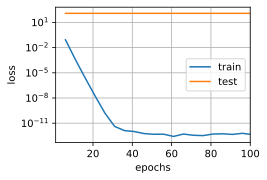

In [8]:
train_gluon(0)

L2 norm of W:  0.03665964


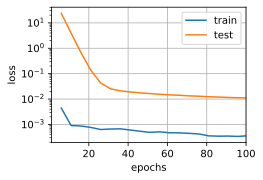

In [9]:
train_gluon(3)